In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler

from scipy import stats

from catboost import CatBoostClassifier, Pool

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

# Downloading data

In [2]:
data_train = pd.read_csv('data_train_preprocessed.csv').drop('Unnamed: 0', axis=1)
data_test = pd.read_csv('data_test_preprocessed.csv').drop('Unnamed: 0', axis=1)
sample_submission = pd.read_csv('content/sample_submission.csv')

In [3]:
dirt_data_train = pd.read_csv('content/train.csv')
dirt_data_test = pd.read_csv('content/test.csv')

In [4]:
dirt_data_train.head()

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...


In [5]:
data_train.head()

,oid,category,text
0,365271984,winter_sport,волшебный фото виктория поплавский евгениямедв...
1,503385563,extreme,возвращение подземелье треш эйфория тупость жа...
2,146016084,football,хороший чешский вратарь – доминик доминатор га...
3,933865449,boardgames,валрак решить подкормить сильно свежий слух им...
4,713550145,hockey,шестёркин затаскивать рейнджерс финал восточны...


In [6]:
data_train['category'].value_counts()

autosport       3160
extreme         3110
martial_arts    3050
motosport       3030
boardgames      3020
tennis          3000
esport          2990
athletics       2970
hockey          2950
volleyball      2950
football        2860
basketball      2850
winter_sport    2800
Name: category, dtype: int64

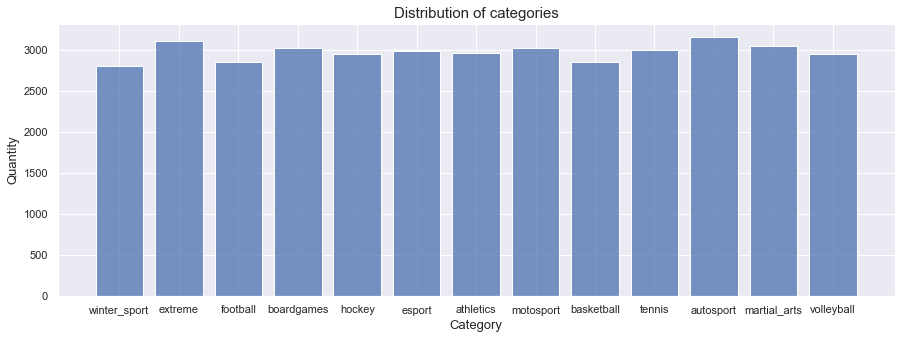

In [7]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.set_style('darkgrid')

plot = sns.histplot(x='category', 
                    data=data_train,
                    palette='gnuplot2_r',
                    shrink=.8);

plot.set_xlabel("Category", fontsize=13)
plot.set_ylabel("Quantity", fontsize=13)
plot.set_title("Distribution of categories", fontsize=15)
plt.show();

# Cleaning Text

In [8]:
import nltk

nltk.download('stopwords')

import re

from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None


data_train['text'] = data_train['text'].str.lower()
data_test['text'] = data_test['text'].str.lower()

data = data_train['text'].apply(lemmatize)
data_test_clear = data_test['text'].apply(lemmatize)

data_train['text'] = data
data_test['text'] = data_test_clear



for i in range(data_train.shape[0]):
    try:
        data_train['text'][i] = " ".join(data_train['text'][i])
    except:
        data_train['text'][i] = "Error"
        
for i in range(data_test.shape[0]):
    try:
        data_test['text'][i] = " ".join(data_test['text'][i])
    except:
        data_test['text'][i] = "Error"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Artemiy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def remove_duplicates(s):
    list_result = []
    list_words = s.split()
    
    for i in list_words:
        if i not in list_result:
            list_result.append(i)
    
    result = ""
    for i in list_result:
        result += i + " "
        
    return result

for i in range(data_train.shape[0]):
    data_train['text'][i] = remove_duplicates(data_train['text'][i])
    
for i in range(data_test.shape[0]):
    data_test['text'][i] = remove_duplicates(data_test['text'][i])

# Learning BERT

In [10]:
from bert_dataset import CustomDataset
from bert_classifier import BertClassifier

Using TensorFlow backend.


In [11]:
classifier = BertClassifier(
    model_path='cointegrated/rubert-tiny',
    tokenizer_path='cointegrated/rubert-tiny',
    n_classes=13,
    epochs=25,
    model_save_path='/content/bert.pt'
)

Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Downloading:   0%|          | 0.00/241k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

In [17]:
bert_data_train = data_train

bert_data_train['label'] = bert_data_train['category'].map({'autosport': 0, 
                                 'extreme': 1, 
                                 'martial_arts': 2, 
                                 'motosport': 3, 
                                 'boardgames': 4, 
                                 'tennis': 5,
                                 'esport': 6,
                                 'athletics': 7,
                                 'hockey': 8,
                                 'volleyball': 9,
                                 'football': 10,
                                 'basketball': 11,
                                 'winter_sport': 12})

In [18]:
from sklearn.model_selection import train_test_split

bert_train, bert_val = train_test_split(bert_data_train, test_size = 0.1)

In [19]:
classifier.preparation(
        X_train=list(bert_data_train['text']),
        y_train=list(bert_data_train['label']),
        X_valid=list(bert_val['text']),
        y_valid=list(bert_val['label'])
)

In [ ]:
classifier.train()

In [ ]:
texts = list(dirt_data_test['text'])

predictions = [classifier.predict(t) for t in texts]
test_predictions = pd.DataFrame({'oid': dirt_data_test['oid'], 'category': predictions})

test_predictions['category'] = test_predictions['category'].map({0: 'autosport', 
                                 1: 'extreme', 
                                 2: 'martial_arts', 
                                 3: 'motosport', 
                                 4: 'boardgames', 
                                 5: 'tennis',
                                 6: 'esport',
                                 7: 'athletics',
                                 8: 'hockey',
                                 9: 'volleyball',
                                 10: 'football',
                                 11: 'basketball',
                                 12: 'winter_sport'})

test_predictions.to_csv('test_bert.csv')

# Learning FastText

In [12]:
import fasttext

train_shuffled = data_train.sample(frac=1)

df_train = pd.DataFrame({'txt': train_shuffled['text'], 'target': train_shuffled['category']})
df_train['target'] = train_shuffled['category'].apply(lambda x: '__label__' + str(x))
df_train[['target', 'txt']].to_csv('train_data.txt', header=False, index=False, sep="\t")

df_test = pd.DataFrame({'txt': data_test['text']})
df_train[['txt']].to_csv('test_data.txt', header=False, index=False, sep="\t")

In [13]:
hyper_params = {"epoch": 20}

model = fasttext.train_supervised(input='train_data.txt', **hyper_params, autotuneValidationFile='test_data.txt')

In [14]:
pred = []

for i in range(data_test.shape[0]):
    pred.append(model.predict(data_test['text'][i])[0][0][9:])
    
test_fasttext = pd.DataFrame({'oid': data_test['oid'], 'category': pred})
test_fasttext.to_csv('test_fasttext.csv')

In [15]:
test_fasttext['category'].value_counts()

esport          2146
winter_sport    2119
hockey          2044
athletics       2042
volleyball      2041
martial_arts    2030
football        2018
tennis          2011
basketball      1986
extreme         1986
motosport       1984
boardgames      1981
autosport       1872
Name: category, dtype: int64

# Training CatBoost

In [16]:
X_train, X_holdout, y_train, y_holdout = train_test_split(data_train.drop('category', axis=1), data_train['category'], test_size=0.20)

In [17]:
from catboost import CatBoostClassifier, Pool

text_features = ['text']

train_dataset = Pool(data=data_train.drop('category', axis=1),
                     label=data_train['category'],
                     text_features=text_features)

eval_dataset = Pool(data=X_holdout,
                     label=y_holdout,
                     text_features=text_features)

In [18]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    # task_type="GPU",
    learning_rate=0.02
)

model.fit(
    train_dataset,
    verbose=False,
    eval_set=eval_dataset,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [28]:
test_dataset = Pool(data_test,
                    text_features=text_features)

predictions = model.predict(test_dataset)

In [29]:
predictions_proba = model.predict_proba(test_dataset)

In [30]:
predictions[0]

array(['esport'], dtype=object)

In [31]:
predictions_proba[0]

array([0.02187347, 0.08607782, 0.02295904, 0.00712051, 0.54203961,
       0.09840622, 0.04689477, 0.04110184, 0.04664495, 0.01522382,
       0.01384211, 0.044232  , 0.01358385])

In [20]:
pred_cb = []

for i in range(0, len(predictions)):
    pred_cb.append(predictions[i][0])

In [41]:
predictions_proba[0]

array([0.02187347, 0.08607782, 0.02295904, 0.00712051, 0.54203961,
       0.09840622, 0.04689477, 0.04110184, 0.04664495, 0.01522382,
       0.01384211, 0.044232  , 0.01358385])

In [42]:
pred_cb_proba = []

for i in range(0, len(predictions_proba)):
    pred_cb_proba.append(max(predictions_proba[i]))

In [43]:
test_catboost = pd.DataFrame({'oid': data_test['oid'], 'category': pred_cb, 'proba': pred_cb_proba})

In [22]:
test_catboost.to_csv('test_catboost.csv')

# Creating Submission

In [45]:
test_bert = pd.read_csv('test_predictions_bert.csv')
test_bert = test_bert.drop('Unnamed: 0', axis=1)

In [47]:
test_bert.shape, test_fasttext.shape

((26260, 2), (26260, 2))

In [56]:
pred = []
oid = []

for i in range(test_bert.shape[0]):
    if test_bert['oid'][i] == test_fasttext['oid'][i] == test_catboost['oid'][i]:
        if test_bert['category'][i] == test_fasttext['category'][i] == test_catboost['category'][i]:
            if test_catboost['proba'][i] > 0.5:
                pred.append(test_bert['category'][i])
                oid.append(test_bert['oid'][i])

In [60]:
len(pred), len(oid)

(19355, 19355)

In [58]:
test_predictions = pd.DataFrame({'oid': oid, 'category': pred})
test_predictions.to_csv('test_predictions.csv')

In [59]:
test_predictions

,oid,category
0,749208109,esport
1,161038103,tennis
2,663621910,esport
3,566255305,tennis
4,770457906,volleyball
...,...,...
19350,965739105,esport
19351,279369911,volleyball
19352,600699419,boardgames
19353,560223506,extreme
